# Multiclass Logistic Regresssion & Intro to Neural Networks
<br>
In this tutorial, we are going to be implementing logistic regression for multiclass scenerios as well as introduce neural networks. For both implementations, we will be using a labelled dataset of handwritten digits from 0-9. The data is in a MATLAB file so we will use scipy to load the data.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fmin_tnc
import random
import math

data = scipy.io.loadmat('ex3data1.mat')
print(data)
print("\nX data: \n", data["X"], "\nShape: " + str(data["X"].shape))
print("\ny data: \n", data["y"], "\nShape: " + str(data["y"].shape))

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), 'y': array([[10],
       [10],
       [10],
       ..., 
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}

X data: 
 [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] 
Shape: (5000, 400)

y data: 
 [[10]
 [10]
 [10]
 ..., 
 [ 9]
 [ 9]
 [ 9]] 
Shape: (5000, 1)


Above we extracted the X matrix of features and y vector of labels, for a total of 5000 rows of data. Each row contains grayscale pixel value for a 20x20 pixel image, which explains wht there are 4000 values in each row. To visualize the data set, we first pick 100 random rows from the dataset (ie visualize 100 images). Then we create a 200x200 matrix (bigImg), reshape each row into a 20x20 matrix (img),"append" or fill each 20x20 region in bigImg and finally display it.

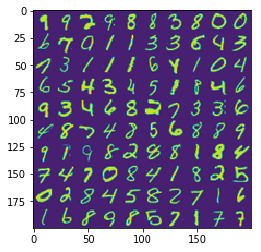

In [35]:
X = random.sample(list(data['X']),100)

def visualizeDigits(X):
    bigImg = np.zeros((200,200))
    
    xIndex = 0
    yIndex = 0
    
    for x in X:
        if xIndex == 200:
            yIndex += 20
            xIndex = 0
        img = np.reshape(x, (20,20)).T
        bigImg[xIndex:xIndex+20,yIndex:yIndex+20] = img
        xIndex += 20
    plt.imshow(bigImg)
    plt.show()
    return

visualizeDigits(X)

As for cost function and gradient implementations for multiclass logisitic regression, we don't have to change anything! 

In [3]:
def sigmoid(x): # same as before
    return 1.0/(1+ np.exp(-x))

def regularizedCost(theta,X,y,lamda): # same as before
    theta_with_0_as_first = np.insert(theta[1:], 0, 0) 
    
    theta = np.matrix(theta)
    m = len(y)
    h = sigmoid(X*theta.T)

    reg_term = (lamda/(2*m))* np.sum(np.square(theta[1:]))
    
    cost = (-y.T * np.log(h) - (1-y).T * np.log(1-h))/m + reg_term
    return cost[0,0]

def regularizedGradient(theta,X,y,lamda): # vectorized implementation same as before
    theta_with_0_as_first = np.insert(theta[1:],0,0)
    
    theta = np.matrix(theta)
    theta_with_0_as_first = np.matrix(theta_with_0_as_first)
    m = len(y)
    error = sigmoid(X*theta.T) - y
    
    regTerm = (lamda/m) * theta_with_0_as_first.T
    gradient = (X.T * error) / m + regTerm # added regTerm
    
    return gradient

When dealing with multiple labels, we use a technique called **One vs all** classification, which means we predict the probability of one class while lumping all the other labels into a seperate class. 

For example, we predict the probability that a label is 1 (compared to the label not being 1), then the probability the label is 2 (compared to the label not being 2) and so on - essentially turning multiclass prediction as a sequence of binary predictions. Our final prediction will be the class which has the highest probability!

Let's implement the oneVsAll method which returns fitted theta parameters for each label (0-9). Thus, the final matrix will be shaped 10x4001 (4001 because includes bias column)

In [40]:
X_data = np.insert(data['X'],0,1,axis=1) # insert column of 1's for bias column
y_data = data['y']

initial_theta = np.zeros(X_data.shape[1])

def oneVsAll(X,y,theta,lamda):
    labels = np.unique(y)
    theta_matrix = []
    for i in labels:
        logicalColumn = y == i
        logicalColumn = logicalColumn.astype(int) 
        # very cool! Creates a boolean column vector such that entries are true if
        # y element == label.
       
        minimum = fmin_tnc(func=regularizedCost, x0=theta, fprime=regularizedGradient, args=(X, logicalColumn, lamda))
        cost = regularizedCost(minimum[0],X,logicalColumn,lamda)
        new_theta = minimum[0]
        theta_matrix.append(new_theta)
    
    return np.array(theta_matrix)

fittedThetaMatrix = oneVsAll(X_data,y_data,initial_theta,1)
print(fittedThetaMatrix)
print("Shape: " + str(fittedThetaMatrix.shape))

[[ -2.37827745e+00   0.00000000e+00   0.00000000e+00 ...,   1.30948202e-03
   -1.90330604e-09   0.00000000e+00]
 [ -3.17635605e+00   0.00000000e+00   0.00000000e+00 ...,   4.47505880e-03
   -5.10127912e-04   0.00000000e+00]
 [ -4.76435216e+00   0.00000000e+00   0.00000000e+00 ...,  -2.88987968e-05
   -2.48560589e-07   0.00000000e+00]
 ..., 
 [ -7.99291366e+00   0.00000000e+00   0.00000000e+00 ...,  -9.06741892e-05
    6.90544592e-06   0.00000000e+00]
 [ -4.56148520e+00   0.00000000e+00   0.00000000e+00 ...,  -1.07424420e-03
    7.87573708e-05   0.00000000e+00]
 [ -5.30419681e+00   0.00000000e+00   0.00000000e+00 ...,  -1.13298887e-04
    9.24805144e-06   0.00000000e+00]]
Shape: (10, 401)


With fitted theta parameters, let's see how accurate it predicts our training data.

In [41]:
def oneVsAllPrediction(theta, X, y): # assuming column of 1's already inserted
    X_matrix = np.matrix(X)
    theta_matrix = np.matrix(theta).T
    
    intermediateMatrix = X_matrix * theta_matrix # 5000 x 10 matrix
    probabilities = sigmoid(intermediateMatrix) # matrix of probabilities
    
    # print(probabilities)
    
    # going to take the argmax (index of max probability) for each row in probabilities matrix
    predicted = np.argmax(probabilities, axis=1)
    
    # for each index, we are going to add 1 for our final label.
    # Ie if index 0 is highest probability, then highest probability label is 1
    # highest probability is index 2 -> label is 3
    # ...
    # highest probability is index 9 -> label is 10
    predicted = np.vectorize(updateIndices)(predicted)
    
    # return accuracy of prediction
    accuracy = getAccuracy(y,predicted)
    return accuracy

def updateIndices(index):
    return index + 1

def getAccuracy(actual,predicted): # returns accuracy between actual and predicted dataset
    logicalColumn = actual == predicted
    logicalColumn = logicalColumn.astype(int)
    
    m = logicalColumn.shape[0]
    numberCorrect = np.sum(logicalColumn)
    return numberCorrect/m

oneVsAllPrediction(fittedThetaMatrix, X_data, y_data)

0.9446

Around 94% for regularization parameter of 1, which is pretty good! Next we are going to be using the same dataset but instead use a simple neural network instead of logistic regression to predict digits. Note that the assignment already gives us predetermined fitted theta parameters for a neural network with 1 hidden layer. Thus all that is needed is to do a series of matrix multiplications along with calculating each layer's **activations** (which is basically applying sigmoid function on each matrix multiplication). Neural networks take effort to fathom so make sure to rewatch the videos to deeply understand them!

In [44]:
data = scipy.io.loadmat('ex3weights.mat')
print(data)
theta1 = data["Theta1"]
print("\nTheta1:\n", theta1)
print("Theta1 shape: " + str(theta1.shape))
theta2 = data["Theta2"]
print("\nTheta2:\n", theta2)
print("Theta2 shape: " + str(theta2.shape))

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011', '__version__': '1.0', '__globals__': [], 'Theta1': array([[ -2.25623899e-02,  -1.05624163e-08,   2.19414684e-09, ...,
         -1.30529929e-05,  -5.04175101e-06,   2.80464449e-09],
       [ -9.83811294e-02,   7.66168682e-09,  -9.75873689e-09, ...,
         -5.60134007e-05,   2.00940969e-07,   3.54422854e-09],
       [  1.16156052e-01,  -8.77654466e-09,   8.16037764e-09, ...,
         -1.20951657e-04,  -2.33669661e-06,  -7.50668099e-09],
       ..., 
       [ -1.83220638e-01,  -8.89272060e-09,  -9.81968100e-09, ...,
          2.35311186e-05,  -3.25484493e-06,   9.02499060e-09],
       [ -7.02096331e-01,   3.05178374e-10,   2.56061008e-09, ...,
         -8.61759744e-04,   9.43449909e-05,   3.83761998e-09],
       [ -3.50933229e-01,   8.85876862e-09,  -6.57515140e-10, ...,
         -1.80365926e-06,  -8.14464807e-06,   8.79454531e-09]]), 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -

Finally, onto implementing our last function `predict`! 

We are given `theta1` with shape (25,401) and `theta2` with shape (10,26). Transposed matrices, `theta1.T` and `theta2.T`, will have shapes (401,25) and (26,10) respectively. Recall that `X_data`'s shape is (5000,401) (401 since we added bias column). First we will multiply `X_data * theta1.T`, which will return a (5000,25) matrix (call it *M*) and then apply the sigmoid function onto *M*. Next we add a bias column to *M* (so its shape will now be (5000,26)) and repeat multiplication of `M * theta2.T` to get a (5000,10) matrix *M2*. Finally we apply the sigmoid function on *M2* and repeat the process of getting the accuracy of our predictions with respect to y_data. This process of applying foward matrix multiplications from the input layer to the output layer is called *feed forwarding*.

In [46]:
# note X_data already has inserted bias column in matrix

def predict(theta1,theta2,X): 
    # predicts labels using TRAINED weights theta1, theta2
    # for neural network with 1 hidden layer and gets accuracy
    # of predictions with respect to y_data
    global y_data
    
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    X = np.matrix(X)
    
    M = sigmoid(X * theta1.T) # 5000x25 matrix
    M = np.insert(M,0,1,axis=1) # 5000x26 matrix
    
    M2 = M * theta2.T # 5000x10 matrix, output layer

    probabilitiesMatrix = sigmoid(M2) # same as before, get index of highest probability
    predicted = np.argmax(probabilitiesMatrix, axis=1)
    predicted = np.vectorize(updateIndices)(predicted)
    accuracy = getAccuracy(y_data, predicted)
    
    return accuracy

predict(theta1,theta2,X_data)

0.97519999999999996

Woohoo! Accuracy of 97.5% which is value we should get as indicated by the assignment. On the next assignment we will continue working with neural networks but in more detail. Specifically we will look at the *backpropagation* algorithm that determines the $\Theta$ trained weights. See you there! :)
